# Model evaluation

You should already have some idea about what is model evaluation. In the motivation example in the first lecture, Jan Maly evaluated the model using its accuracy. During the last two lectures, Niek was using the F1 score for model performance evaluation. Let's dig a bit deeper into this problem a learn how to evaluate ML models.

## Classification

## Binary classifier

As the name suggests binary classifier splits data into two classes. Binary classifiers usually predict one value or __score__ for each data sample on its input. The score is usually normalized (values between 0.0 and 1.0) and indicates the models certainty that the given sample belongs to the positive class. 

The score itself would not be enough to split data into two classes - you also need __decision threshold__ (sometimes decision boundary or cut-off). Any observations with scores higher than the decision threshold are predicted as the positive class (value `1` or `True`), and scores lower than the decision threshold are predicted as the negative class (value `0` or `False`).

Don't get confused by the terminology of _positive / negative_ or _True / False_ that you would expect for example for a SPAM detection classifier. You can use a binary classifier any time you need to split your data into two groups. For example, you can [download the Cats vs. Dogs dataset](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset) and assign `1` to Dogs and `0` to Cats (or vice versa if you are a cat person :) ) and use some binary classifier for the job.

Let's use the most common output of the binary classifier. That is output for one data sample is one number between `0.0` and `1.0`. So for the whole dataset, you would get many values and you can create a histogram of these values to see it's distribution. Here is an example of such a histogram:

![Binary Classification](images/binary_classification.png)

The `x` axes show scores from `0.0` to `1.0` and the `y` axes show the volume of predictions for a particular score. [[image credit]](https://docs.aws.amazon.com/machine-learning/latest/dg/binary-model-insights.html)

OK time to look at some example results and evaluate the model that produces them. We will use artificial results to show you how the change of output distribution affects metrics.
But for now, let's pretend we have trained the ML model for SPAM detection. Input to the model is an email and output is the score from 0.0 to 1.0. Where 0.0 means that the model predicts that the given email is not SPAM and 1.0 means that the model is 100% sure the given email is SPAM.

The following code will generate two output distributions - one for negative (normal email) and one for positive results (SPAMs). We plot these results and then combine them together to simulate the output of the ML model on the testing dataset.

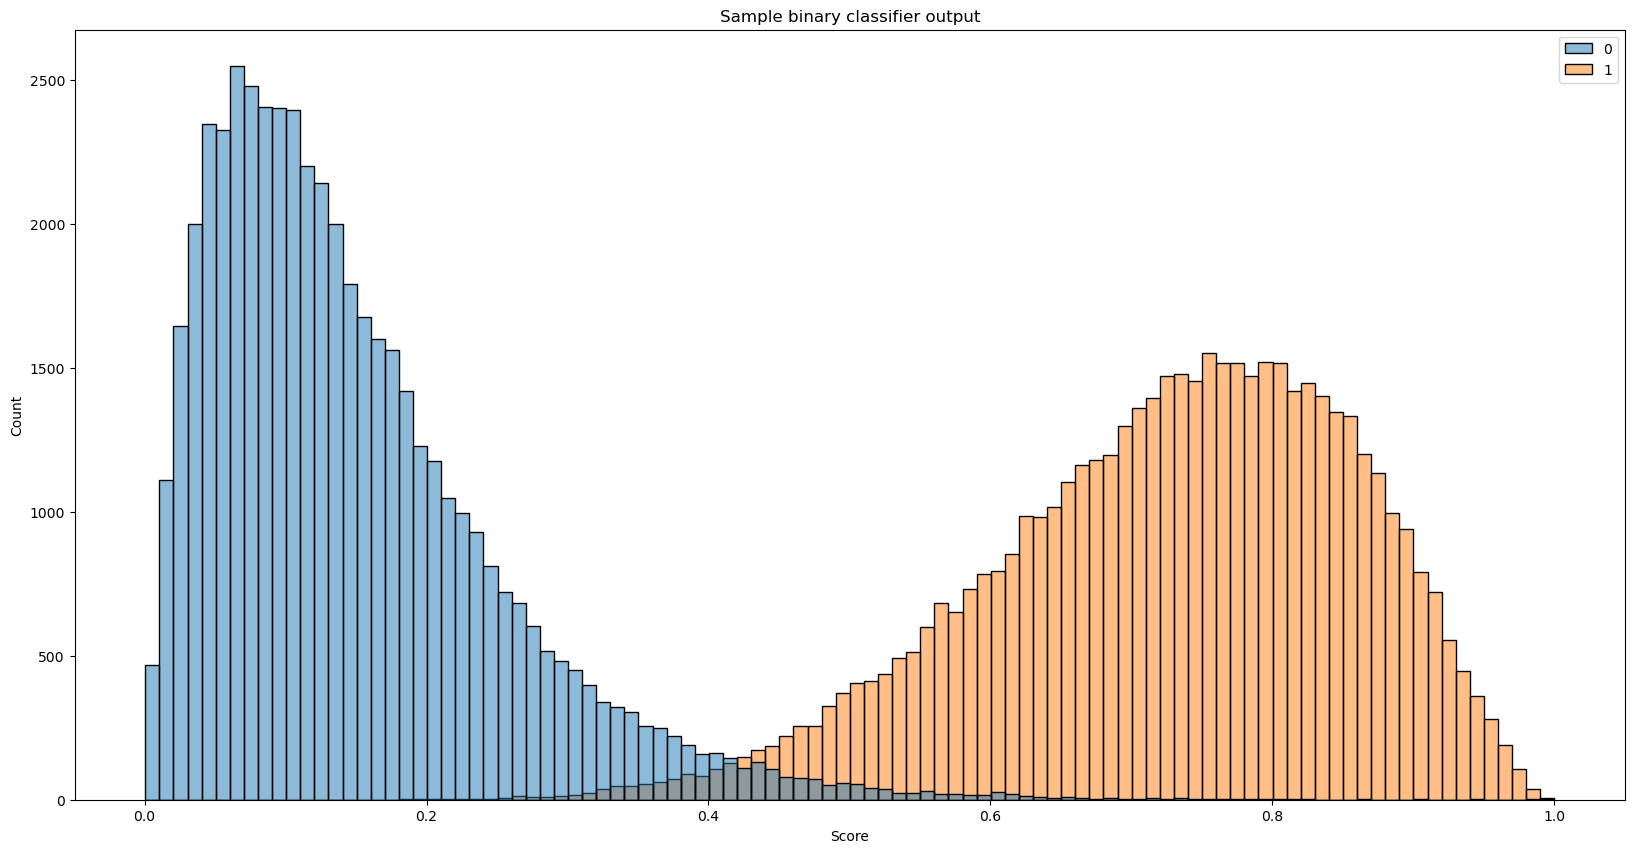

In [1]:
# Import visualization libs (seaborn and matplitlib), scipy for statistical distributions and some other libs for later
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, beta
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Generate random negative and positive sample scores
n_samples = 50000
negative_samples = gamma.rvs(2, size=n_samples)
positive_samples = beta.rvs(8, 3, size=n_samples)

# Normalize outputs to stay in 0.0 to 1.0 range
negative_samples = negative_samples/max(negative_samples)
positive_samples = positive_samples/max(positive_samples)

# Plot histogram of both distributions
_, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=[negative_samples, positive_samples], bins=100)
_ = ax.set_title('Sample binary classifier output')
_ = ax.set(xlabel='Score')

# Combine both distributions to predicted scores and expected correct scores
predicted_scores = list(negative_samples) + list(positive_samples)
true_labels = [0]*len(negative_samples) + [1]*len(positive_samples)

### Important metrics to start with:

### TP (True Positive)

**Description:** A test result that correctly indicates the presence of a condition or characteristic

**In our example:** `SPAM` email classified correctly as `SPAM`

### TN (True Negative)

**Description:** A test result that correctly indicates the absence of a condition or characteristic

**In our example:** `Normal email` classified correctly as `normal email`

### FP (False Positive)

**Description:** A test result which wrongly indicates that a particular condition or attribute is present

**In our example:** `Normal email` classified incorrectly as `SPAM`

### FN (False Negative)

**Description:** A test result which wrongly indicates that a particular condition or attribute is absent

**In our example:** `SPAM` classified incorrectly as `normal email`

How to compute these metrics in our example? Let's look at the output of the classifier and correct labels.

In [2]:
print('Correct\t\tReal\noutput\t\toutput\n----------------------')
for _ in range(10):
    index = random.randint(0, len(true_labels))
    print(f'{true_labels[index]}\t\t{predicted_scores[index]:.3f}')

Correct		Real
output		output
----------------------
1		0.791
0		0.231
0		0.263
0		0.113
1		0.678
1		0.344
1		0.521
1		0.613
0		0.277
0		0.202


We are missing the decision threshold to convert output score into one of the classes! 

What number would you chose for the decision threshold without even looking at the results?

And what number would you chose for the decision threshold if you look at our output distribution?

True positives: 47243
True negatives: 49575
False positives: 425 (normal emails classified as SPAM)
False negatives: 2757 (SMAP classified as normal email)


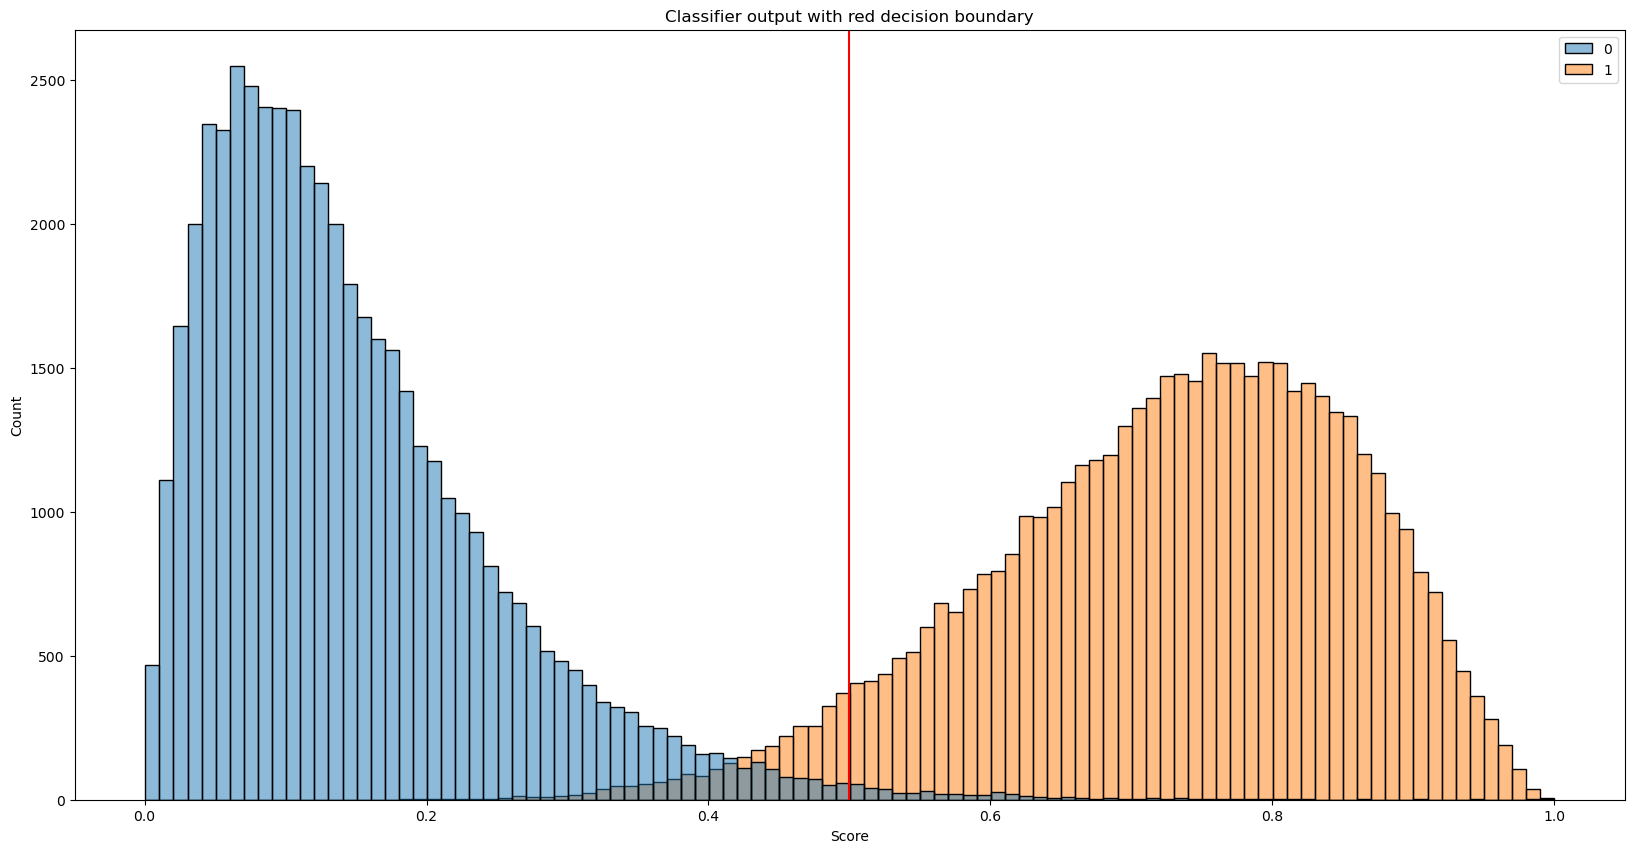

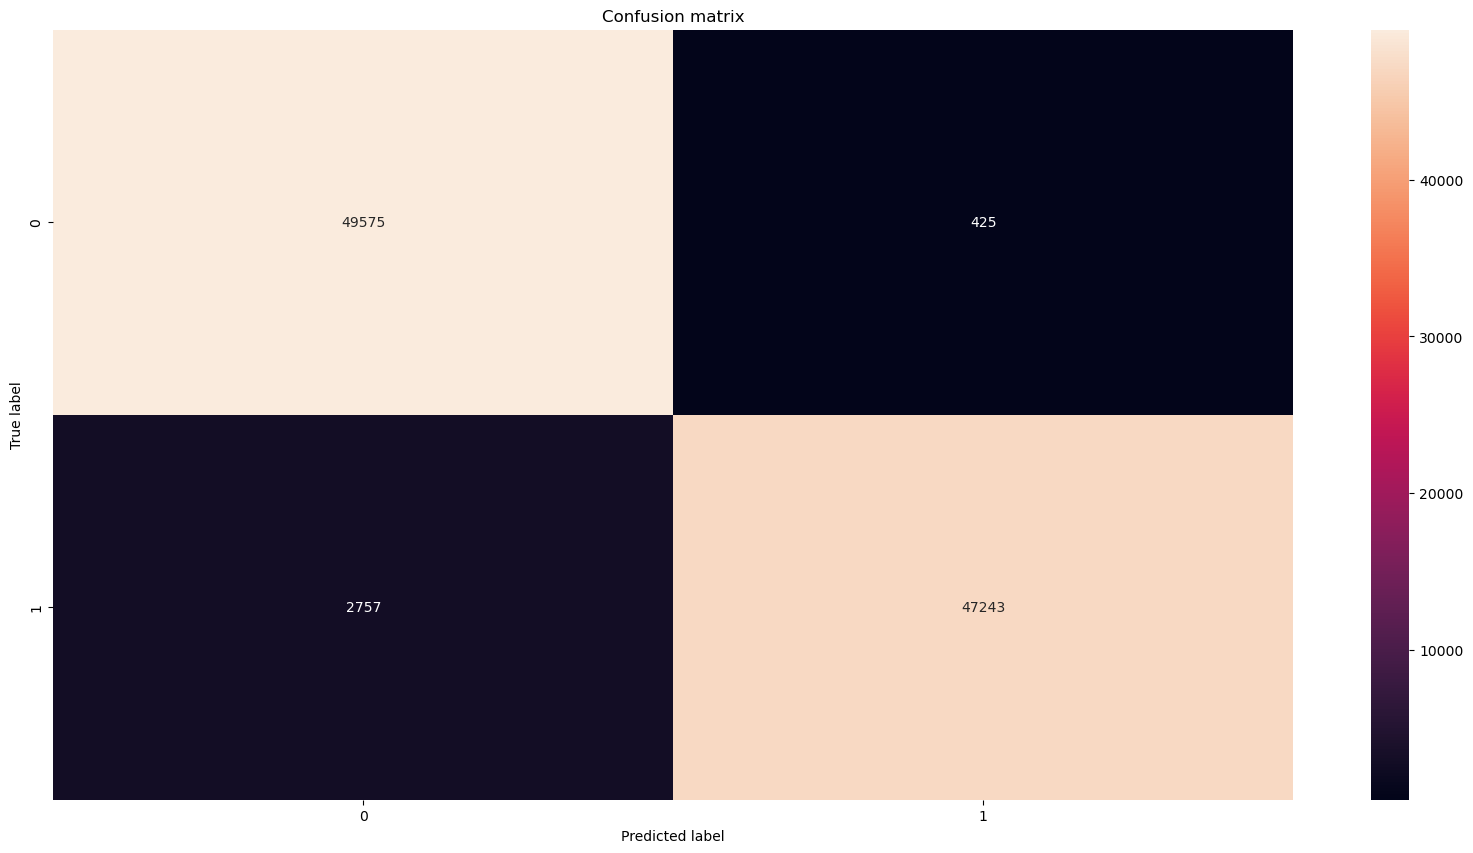

In [3]:
# Play with the threshold value and see how the resuls change
threshold = 0.5

predicted_lables = [1 if label > threshold else 0 for label in predicted_scores]

# Plot histogram with decision threshold
_, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=[negative_samples, positive_samples], bins=100)
plt.axvline(x=threshold, color='red')
_ = ax.set_title('Classifier output with red decision boundary')
_ = ax.set(xlabel='Score')

# Print confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(20,10))
cm = confusion_matrix(true_labels, predicted_lables, normalize=None)
sns.heatmap(cm, annot=True, ax=ax, fmt='d')
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Print TP, TN, FP and FN
print(f'True positives: {cm[1, 1]}\nTrue negatives: {cm[0, 0]}')
print(f'False positives: {cm[0, 1]} (normal emails classified as SPAM)\nFalse negatives: {cm[1, 0]} (SMAP classified as normal email)')

We can combine TP, TN, FP, and FN into useful metrics that can tell us more about our classifier in just one number.

The most common ones are:

### Accuracy

Accuracy (acc) is a proportion of correct predictions among the total number of examined samples.

In our case, this is a proportion of correctly classified emails among all emails.

$ acc = \dfrac{TP + TN}{TP + TN + FP + FN} $

### Precision

Precision attempts to answer the following question: `What proportion of positive identifications was actually correct?`

In our case, it is a fraction of `correctly classified SPAMs (TP)` among all emails labeled by the model as `SPAM`

$ precision = \dfrac{TP}{TP + FP} $

### Recall

Recall attempts to answer the following question: `What proportion of actual positives was identified correctly?`

In our case, it is a fraction of `correctly classified SPAMs (TP)` among all correctly plus incorrectly classified emails marked as `SPAM`

$ recall = \dfrac{TP}{TP + FN} $

You can find many more metrics based on TP, TN, FP, and FN [here](https://en.wikipedia.org/wiki/Precision_and_recall)

Let's compute accuracy, precision, and recall for our example.

In [4]:
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

acc = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print(f'Accuracy: {acc:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}')

Accuracy: 0.9682
Precision: 0.9911
Recall: 0.9449


We already mentioned the F1 score in previous lectures but what it is actually?

### F1 score

F1 score combines precision and recall into a single metric by taking their harmonic mean.

$ F_1 = 2 \dfrac{precision * recall}{precision + recall} = \dfrac{2TP}{2TP + FP + FN}$

In the F1 score the relative contribution of precision and recall to the F1 score are equal. But sometimes recall is a litle more important for us than precision, sometimes recall is much more important for us than precision, and sometimes the opposite. This is where $F_\beta$ score comes in.

### $F_\beta$ score

A more general F score that uses a positive real factor $\beta$, where $\beta$ is chosen such that recall is considered $\beta$ times as important as precision.

Two commonly used values for $\beta$ are 2, which weighs recall higher than precision, and 0.5, which weighs recall lower than precision.

$ F_\beta = (1+\beta^2)\dfrac{precision * recall}{(\beta^2 precision) + recall} = \dfrac{(1+\beta^2)TP}{(1+\beta^2)TP + \beta^2 FN + FP}$

In [5]:
f1 = 2*(recall*precision)/(recall+precision)

def f_beta(beta, precision, recall):
    return (1 + beta**2)*precision*recall/((beta**2 * precision) + recall)

f2 = f_beta(2, precision, recall)
f05 = f_beta(0.5, precision, recall)

print(f'f1 score: {f1:.4f}\nf2 score: {f2:.4f}\nf0.5 score: {f05:.4f}')

f1 score: 0.9674
f2 score: 0.9538
f0.5 score: 0.9815


### ROC - AUC

**Receiver operating characteristic curve (ROC)** or **Area Under the Curve (AUC)** is equal to the probability that the model will rank a randomly chosen positive sample higher than a randomly chosen negative one.

Can you guess what is the meaning of the red line?

AUC = 0.9977248458


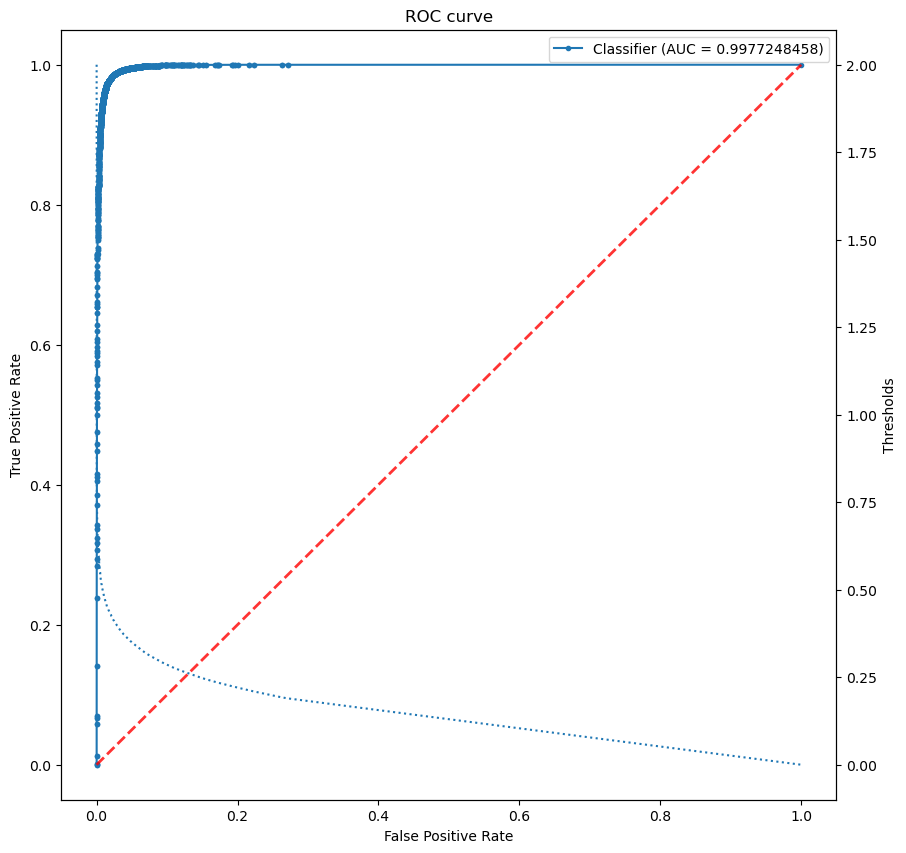

In [6]:
# Plot AUC (ROC)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# compute metrics
score = roc_auc_score(true_labels, predicted_scores)
first_m, second_m, thresholds = roc_curve(true_labels, predicted_scores)
print(f'AUC = {score}')

# plot classifier
ax.plot(first_m, second_m, marker='.', label=f'Classifier (AUC = {score})')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# plot thresholds
ax2 = ax.twinx()
ax2.plot(first_m[:len(thresholds)], thresholds, linestyle=':')
ax2.set_ylabel('Thresholds')
    
# annotate plot
ax.set_title('ROC curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# show legend
_ = ax.legend()

## Multiclass classifier

Now that we know what is a binary classifier and how to measure its performance lets one up the game and take a look at the multiclass classifier!

As you can guess the main difference is that multiclass classifiers produce multiple output values or __scores__ for one input. The scores indicate the model's certainty that the given observation belongs to each of the classes. We mentioned [the Cats vs. Dogs dataset](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset) at the beginning of this notebook. Let's look back at this example in the following image:

![binary vs multiclass example](images/binary_vs_multiclass.png)

As you can see we can reimagine any binary classification problem into a multiclass classification problem with two outputs! __But it is almost always better to stick with the binary classification if possible!__. Multiclass classifiers are best for cases when you have more than 2 classes. An example of such a classifier could be the handwritten digits classifier Niek showed you last week with 10 classes for digits 0 to 9. Or object detection classifier trained on the [imagenet dataset](https://huggingface.co/datasets/imagenet-1k) with 1000 classes - one class for one object on the image like `plane`, `bike`, `car`, `horse`, ... 

There is one crucial difference between binary and multiclass classifiers when it comes to output interpretation! With a multiclass classifier, you don't need the decision threshold! __The predicted answer is the class with the highest predicted score.__

But can we still use the same evaluation metrics as for the binary classifier?

We can either interpret results similary as with binary classifier and focus only on the answer to a simple question: is the output class with the highest score the correct one? Or we can get more valuable information about the performance of the classifier for each class separately and discover more information about what classes are problematic for our model and so on. But let's show it in the example!

We are going to train simple Convolutional Neural Network on the CIFAR-10 dataset. 

In [7]:
# Start with import of some necessary libs. We are going to use score metrics from sklearn this time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, top_k_accuracy_score
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np

In [8]:
# Get cifar10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Convert labels to one-hot-encoding
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=10)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


What is one hot encoding? Label in our example with 10 classes of images is a number from 0 to 9 like this one:

In [9]:
int(train_labels[0])

6

But our model will have 10 outputs (one for each class) where the output with the highest score is the predicted class. So what would be the ideal output of our neural net where we want `6` to be the highest score?

It can for sure be something like this:

`[0, 1, 2, 3, 4, 5, 600000, 7, 8, 9]`

But we want normalized outputs and we also want to minimize the score for the other classes. So:

In [10]:
train_labels_onehot[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

We are ready to create convolutional neural network for image classification. Here is the scheme of our network:

![convolutional neural network](images/cnn.png)

In [11]:
# Let's define our CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Complie the model and define optimizer, loss function and metrics we want to measure
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# And we can train our model
history = model.fit(train_images, train_labels_onehot, epochs=20)

2022-10-17 09:50:58.580975: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 09:50:59.570786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.7509 - accuracy: 0.3567
Epoch 2/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.2233 - accuracy: 0.5651
Epoch 3/20
1563/1563 [==============================] - 16s 11ms/step - loss: 1.0452 - accuracy: 0.6326
Epoch 4/20
1563/1563 [==============================] - 16s 11ms/step - loss: 0.9413 - accuracy: 0.6714
Epoch 5/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8577 - accuracy: 0.6996
Epoch 6/20
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7943 - accuracy: 0.7243
Epoch 7/20
1563/1563 [==============================] - 18s 11ms/step - loss: 0.7344 - accuracy: 0.7411
Epoch 8/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6882 - accuracy: 0.7565
Epoch 9/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6479 - accuracy: 0.7703
Epoch 10/20
1563/1563 [==============================] - 17s 11m

In [12]:
# Let's check how well we did on the testing set
predicted_output = model.predict(test_images)

# And focus on one prediction
one_prediction = [f'{value:.4f}' for value in predicted_output[0]]
print(f'One image prediction looks like this: {one_prediction}')
print(f'Correct label: {test_labels[0]}')

# Convert one-hot-encoding back to single number for better readibility
predicted_labels = np.argmax(predicted_output, axis=1)
acc = accuracy_score(test_labels, predicted_labels)
print(f'Test accuracy: {acc:.4f}')

One image prediction looks like this: ['0.0001', '0.0001', '0.0000', '0.9098', '0.0001', '0.0895', '0.0000', '0.0000', '0.0001', '0.0003']
Correct label: [3]
Test accuracy: 0.7013


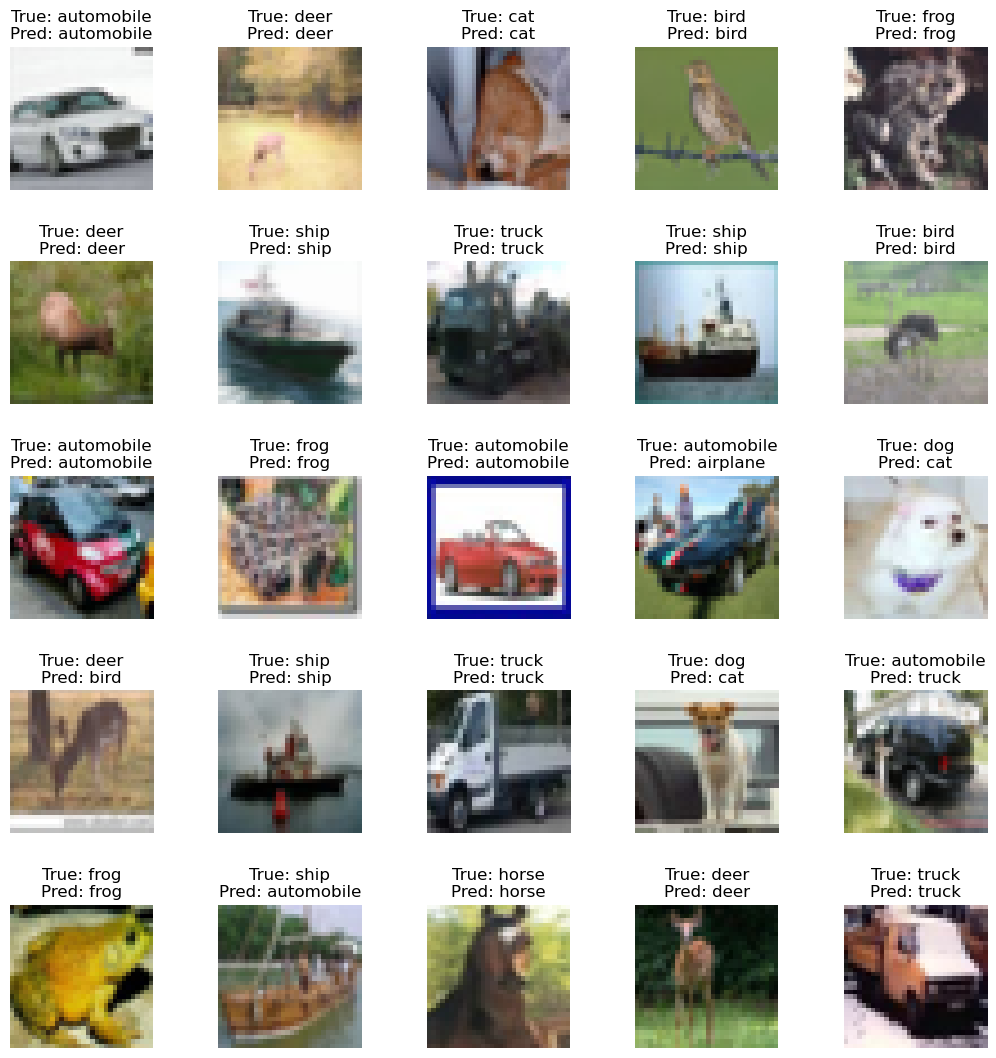

In [13]:
# Let's plot some of the predictions to see where the model was correct and where it was wrong

# Dictionary for converting class number to label
id_to_label = { 
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

# Plot few random images with true label and predicted label
plt.figure(figsize=(13,13))
for img_num in range(25):
    ax = plt.subplot(5, 5, img_num+1)
    img_id = random.randint(0, len(test_labels))
    plt.imshow(test_images[img_id])
    plt.subplots_adjust(hspace=0.5)
    plt.title(f'True: {id_to_label[int(test_labels[img_id])]}\nPred: {id_to_label[int(predicted_labels[img_id])]}')
    plt.axis("off")

Now let's evaluate our multiclass classifier as we did before with the binary classifier. We already have accuracy and we can use `sklearn` to compute the f1 score, precision, and recall.

In [14]:
# Compute TP, TN, FP, FN, ACC, Precision, Recall, F1 and AUC for the top 1 as the whole
f1 = f1_score(test_labels, predicted_labels, average='macro')
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')

print(f'F1 score: {f1:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}')

F1 score: 0.7009
Precision: 0.7025
Recall: 0.7013


But what if we look at each class separately? If the number of classes is reasonably low (as in our example), you can use a confusion matrix as a great tool to visualize evaluation metrics for the multiclass classifier.

In [15]:
class_correct = [0]*10
class_total = [0]*10
accuracies = []

for i in range(len(test_labels)):
    true_label = int(test_labels[i])
    class_total[true_label] += 1
    if true_label == int(predicted_labels[i]):
        class_correct[true_label] += 1

print('Accuracy per class:')
for i in range(10):
    acc = float(class_correct[i])/class_total[i]
    accuracies.append(acc)
    print(f'{id_to_label[i]}:\t{acc}')

print(f'\nMean of the numbers above should be the same test accuracy few cells above.\nLet\'s check it: {np.mean(accuracies):.4f}')

Accuracy per class:
airplane:	0.78
automobile:	0.815
bird:	0.581
cat:	0.504
deer:	0.655
dog:	0.635
frog:	0.775
horse:	0.743
ship:	0.792
truck:	0.733

Mean of the numbers above should be the same test accuracy few cells above.
Let's check it: 0.7013


Now we can take a look at a little different kind of confusion matrix than before. This one will show us the counts of true labels bs predicted labels by out model.

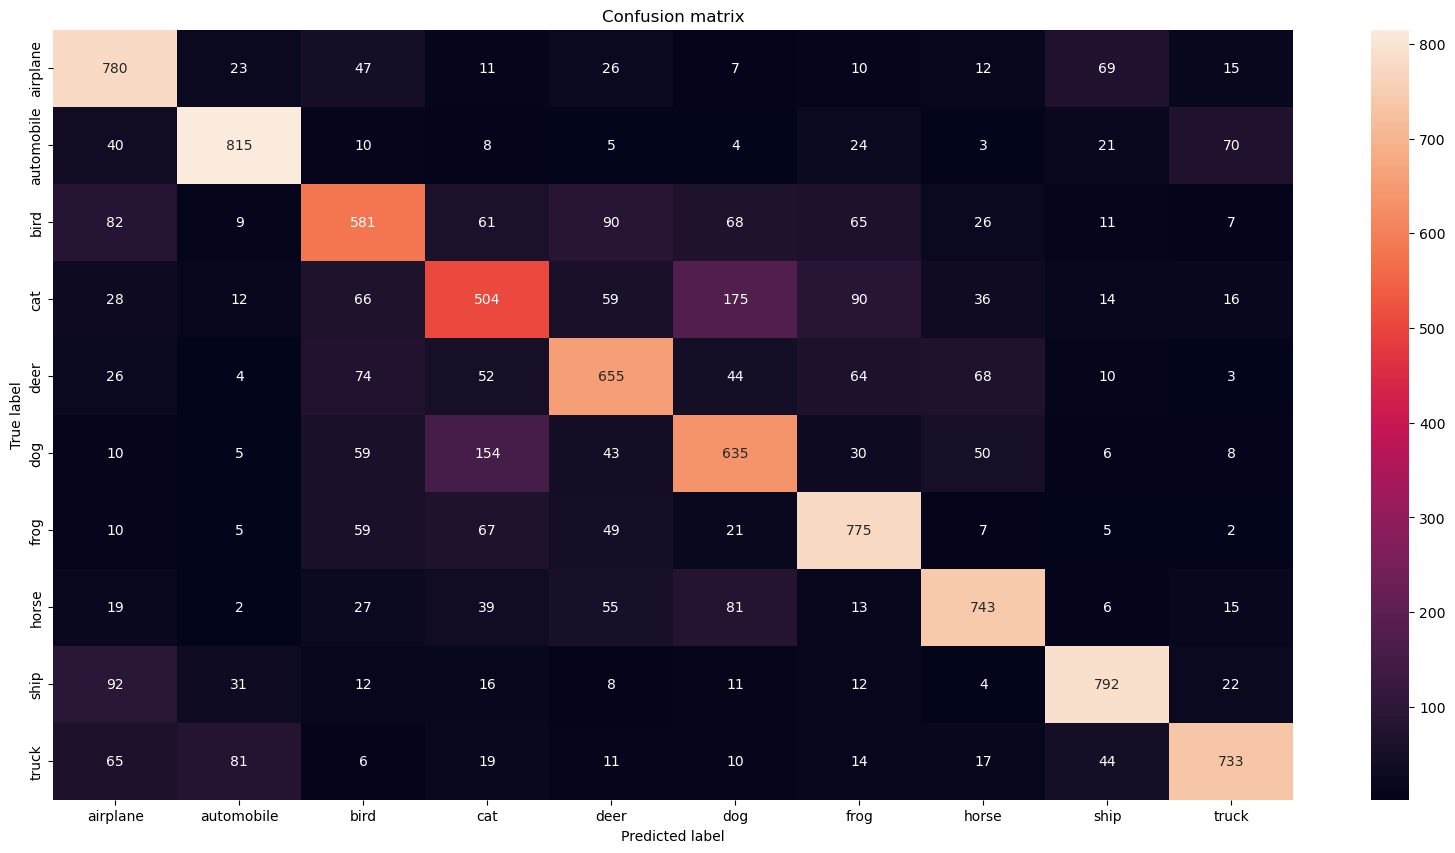

In [16]:
cm = confusion_matrix(test_labels, predicted_labels)

fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.heatmap(cm, annot=True, ax=ax, fmt='d', xticklabels=id_to_label.values(), yticklabels=id_to_label.values())
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
_ = ax.set_xlabel('Predicted label')

Another very useful metric is `top_k`. Usually, you are interested in the `correct prediction` only. But sometimes (especially when you have many classes) you want to know if the correct prediction is in the top k of predictions. Depending on the number of classes the most common values for `k` are `2`, `3`, `5` or `10`.

In [17]:
for k in [1,2,3,5,10]:
    top_k_acc = top_k_accuracy_score(test_labels, predicted_output, k=k)
    print(f'Top {k} accuracy is {top_k_acc:0.4f}')

Top 1 accuracy is 0.7013
Top 2 accuracy is 0.8535
Top 3 accuracy is 0.9187
Top 5 accuracy is 0.9734
Top 10 accuracy is 1.0000


/Users/lukas/opt/anaconda3/envs/ds-academy/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1777: UndefinedMetricWarning: 'k' (10) greater than or equal to 'n_classes' (10) will result in a perfect score and is therefore meaningless.
  warnings.warn(


__One last note for multiclass classification__: Remember the trick in the begining of this section where we seen that you can make multiclass classifier out of any binary classifier? You can also do this trick in the oposite direction and reimagine any multiclass classification problem with `N` classes as a binary classification problem with `N` binary classifiers, which can be often helpful.

## Regression models

Regression models predict a continuous value based on the input. You have already met the example of such a model in the third lecture - the linear regression model. Does anyone remember what was the metric Niek used to measure its performance?
Let's create a simple time series prediction model to show what kind of metrics you can use.

In [18]:
import math
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

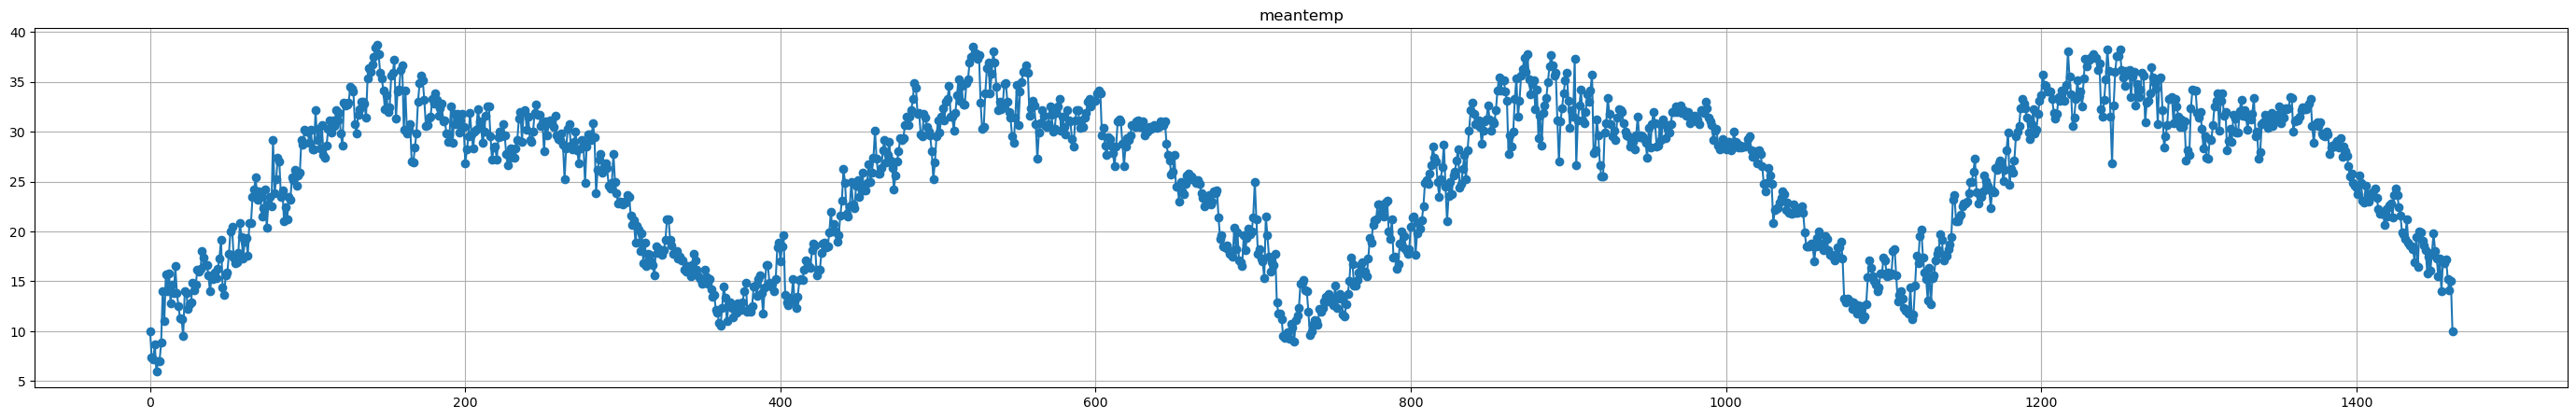

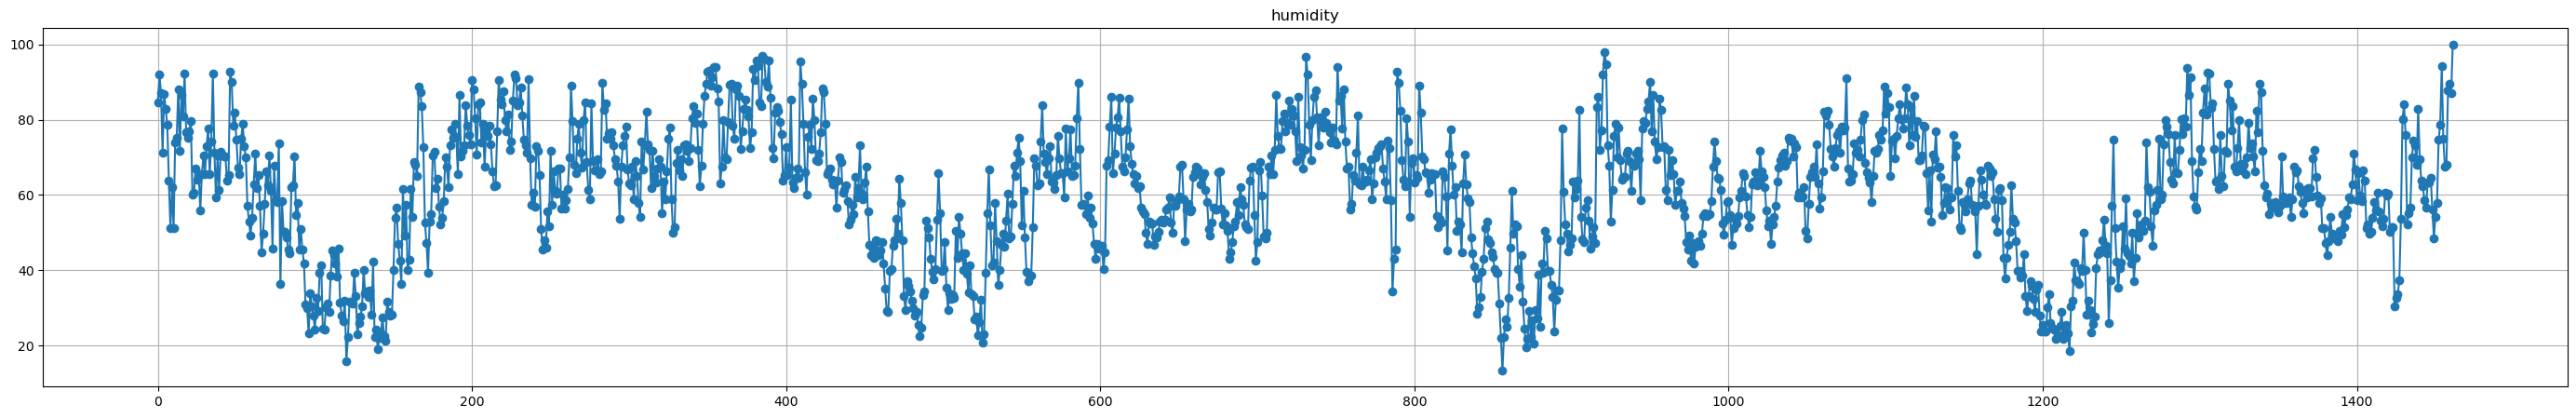

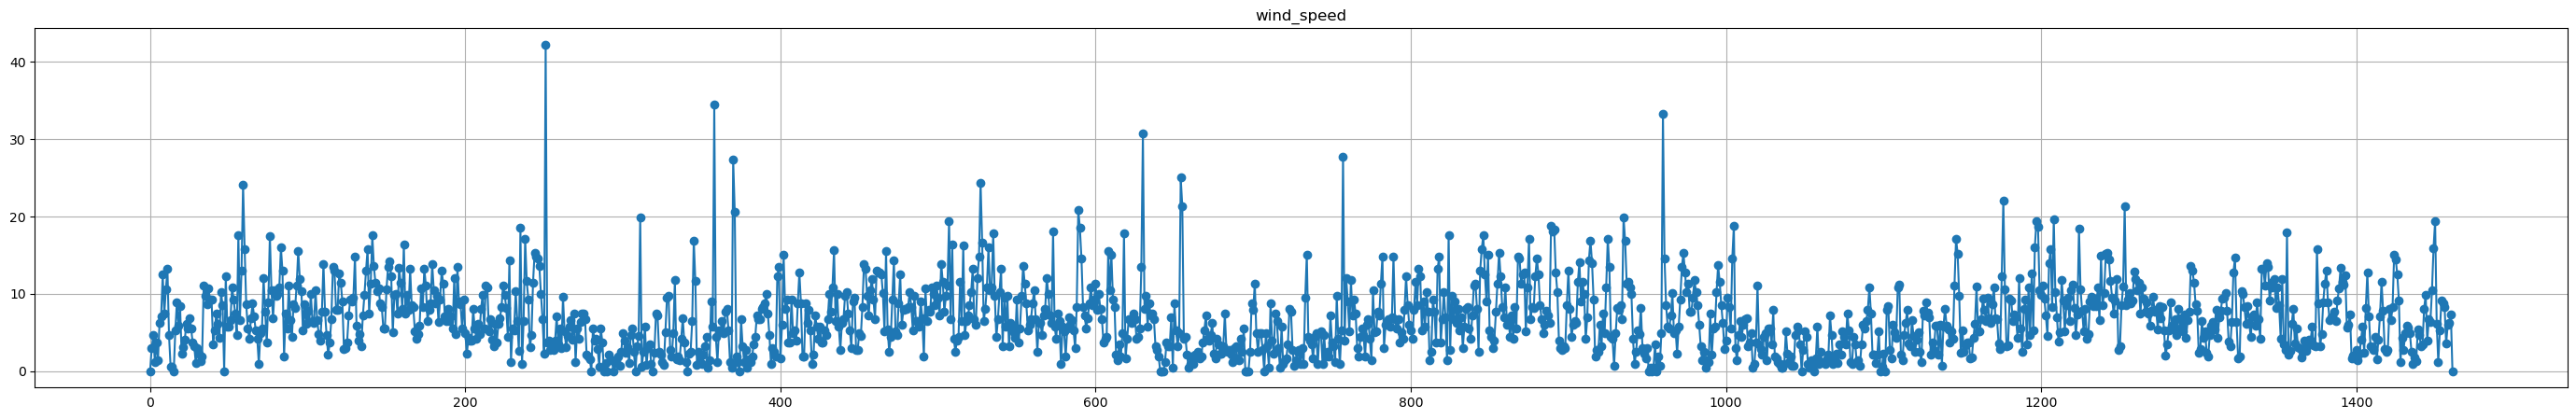

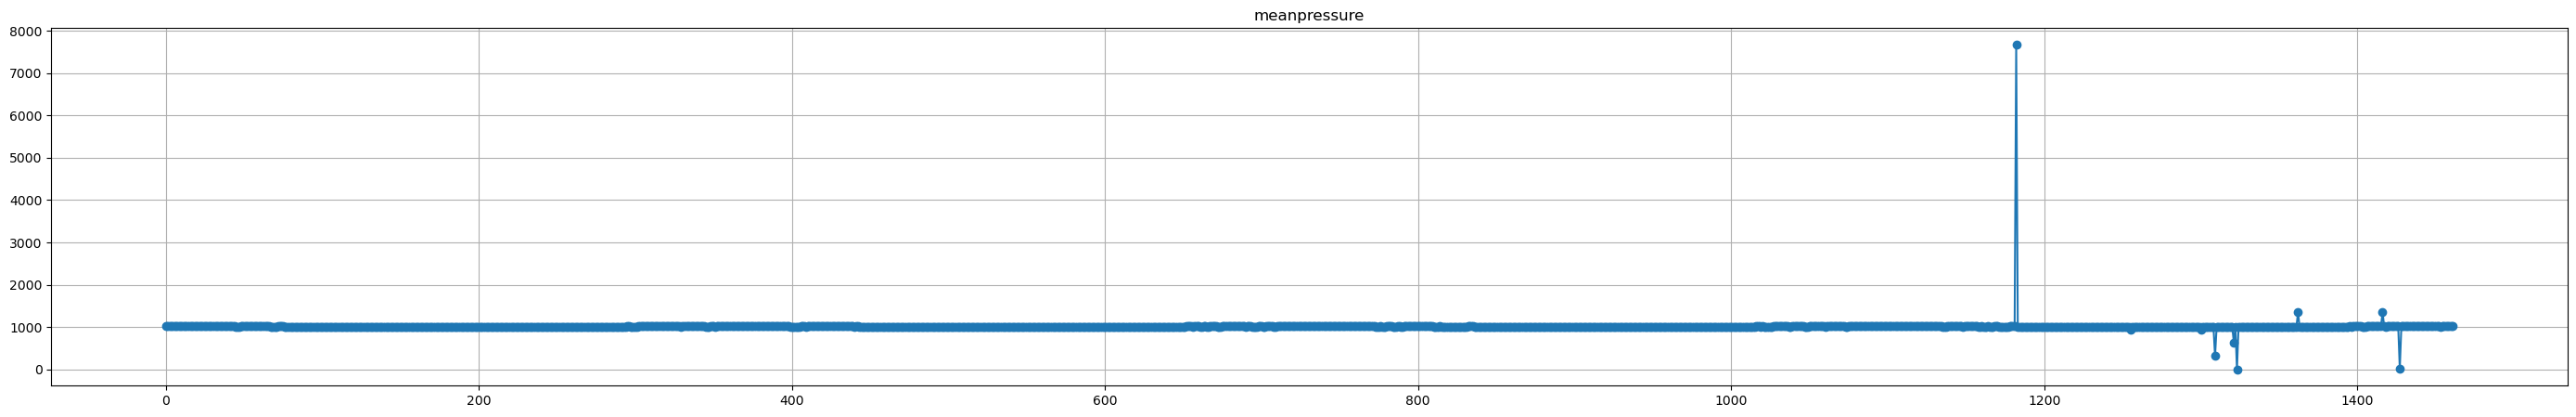

In [19]:
# Read the data and plot all time series
raw_data = pd.read_csv('data/DailyDelhiClimateTrain.csv')

for i in raw_data.drop(columns='date').columns:
    plt.figure(figsize=(35,5))
    plt.plot(raw_data[i], label=i, marker='o')
    plt.title(i)
    plt.grid()
    plt.show()


In [20]:
X_train = raw_data[['humidity', 'wind_speed', 'meanpressure']]
y_train = raw_data['meantemp']

scaler = MinMaxScaler(feature_range=(0,1))
all_data = scaler.fit_transform(np.array(raw_data['meantemp']).reshape(-1,1))

training_size = int(len(all_data)*0.7)
test_size = len(all_data)-training_size
train_data, test_data = all_data[0:training_size,:], all_data[training_size:len(all_data),:1]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [21]:
model = RandomForestRegressor(n_estimators=10, random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

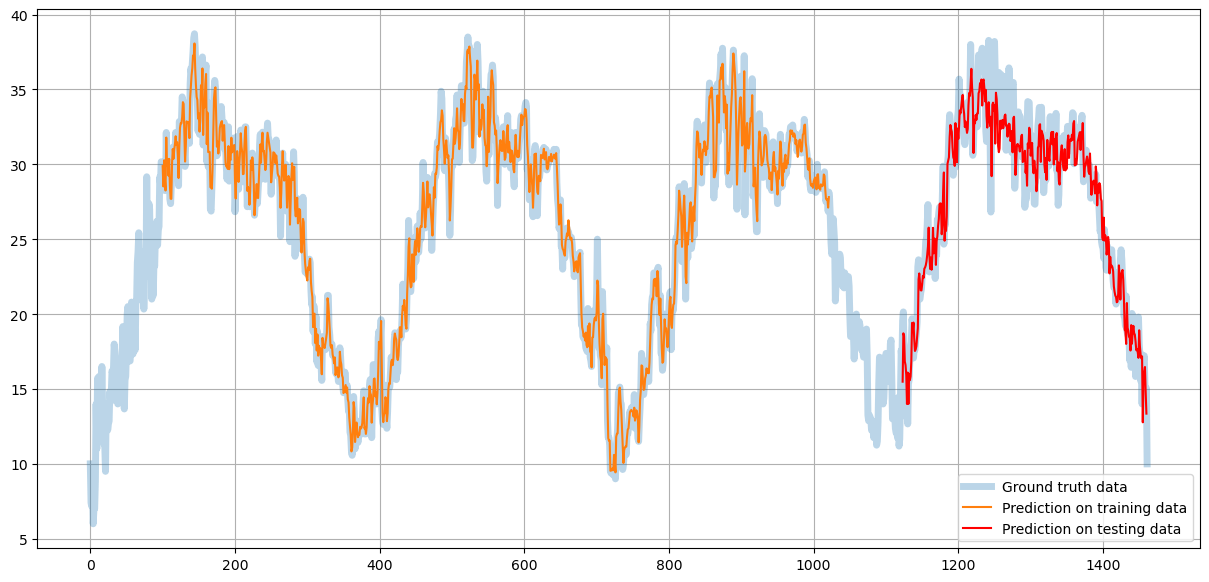

In [22]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1,1))

train_predict = model.predict(X_train)
train_predict = scaler.inverse_transform(train_predict.reshape(-1,1))


# Shift train predictions for plotting
look_back=100
train_prediction_data = np.empty_like(all_data)
train_prediction_data[:, :] = np.nan
train_prediction_data[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
test_prediction_data = np.empty_like(all_data)
test_prediction_data[:, :] = np.nan
test_prediction_data[len(train_predict)+(look_back*2)+1:len(all_data)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(all_data), alpha=0.3, linewidth=5)
plt.plot(train_prediction_data)
plt.plot(test_prediction_data, color='red')
plt.legend(['Ground truth data', 'Prediction on training data', 'Prediction on testing data'])
plt.grid()
_ = plt.show()

You can see that the orange line (prediction on the training data) fits the ground truth data almost perfectly - __the model learns training data__.

Red line showing the prediction on the testing data is less precise but still very close to the original data maintaining the low-frequency trends.

We saw the usage of MSE for loss function during training. Let's dig deeper into what it is and talk about some other metrics.

### Mean Absolute Error (MAE)

One of the most comon ways to evaluate regression model is Mean Absolute Error.  

$ MAE = \dfrac{1}{n}\sum_{i=1}^{n} |y_i - x_i|$

Where $n$ is number of data samples, $y_i$ is the actual value of i-th data sample, and $x_i$ is the predicted value of i-th data sample.

### Mean Squared Error (MSE)

Similar to MAE is MSE with the only difference beeing the square of the error instead of just difference. This means that MSE penalizies outliers much more then MAE.

$ MSE = \dfrac{1}{n}\sum_{i=1}^{n} (y_i - x_i)^2$

Where $n$ is number of data samples, $y_i$ is the actual value of i-th data sample, and $x_i$ is the predicted value of i-th data sample.

### Root Mean Squared Error (RMSE)

Sometimes you want to use MSE instead of MAE but you need the error in the same units as the data. Just taking the root of the MSE will do the trick.

$ RMSE = \sqrt{MSE} = \sqrt{\dfrac{1}{n}\sum_{i=1}^{n} |y_i - x_i|}$

Where $n$ is number of data samples, $y_i$ is the actual value of i-th data sample, and $x_i$ is the predicted value of i-th data sample.
 
### R2 Score (R2)

R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. Gains values from 0 to 1 where 1 is the best possible result.

$ R^2 = \dfrac{SSR}{SST} = \dfrac{\sum_{i=1}^{n} (\^{y_i} - \bar{y})^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $

Where $SSR$ is the Sum of Squares of Residuals, $SST$ is Sum of Squares Total, $\^{y_i}$ represents the prediction or a point on the regression line, $y_i$ represents the actual ground truth values, and $\bar{y}$ represents the mean of all the values.


In [23]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))
print(f'R2 score: {r2_score(y_test_scaled, test_predict):.4f}')
print(f'MAE: {mean_absolute_error(y_test_scaled, test_predict):.4f}')
print(f'MSE: {mean_squared_error(y_test_scaled, test_predict):.4f}')
print(f'RMSE: {math.sqrt(mean_squared_error(y_test_scaled, test_predict)):.4f}')


R2 score: 0.9137
MAE: 1.4095
MSE: 3.2064
RMSE: 1.7907
